In [1]:
import time
import warnings
import h3
import kds
import keplergl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import sweetviz as sv
import ydata_profiling as df_report
from pytz import timezone

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import (mean_absolute_error,
                             mean_absolute_percentage_error,
                             mean_squared_error, r2_score)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from tzfpy import get_tz

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')


### Load data from private dataset and public dataset

In [2]:
df_usage = pd.read_csv('data/usage_data_2023_05_01_to_15.csv')
display(df_usage.head(2))
df_airtraffic_trends = pd.read_csv('data/Airline_Transportation_Data.csv')
display(df_airtraffic_trends.head(2))

,AIRLINE,TAIL_ID,USAGE_TSTAMP,PREMIUM_PRODUCT,ESI_PRODUCT,TMO_PRODUCT,BASIC_PRODUCT,OTHER_PRODUCT,DOOR_CLOSE_TSTAMP,DOOR_OPEN_PLUS15_TSTAMP,TIME_INTO_FLIGHT,FLIGHT_PHASE,LATITUDE,LONGITUDE,ALTITUDE,TOTAL_FL_MBPS,TOTAL_RL_MBPS,SEAT_CAPACITY,ECO_SEATS
0,AAL,N314PD,2023-05-04T01:20:00Z,1,0,0,0,1,2023-05-04T00:00:52.341Z,2023-05-04T02:04:59.387Z,80.0,10k,27.33,-80.38,29175.63,6.93,1.16,172.0,114.0
1,DAL,N384DA,2023-05-04T01:20:00Z,1,0,0,0,1,2023-05-03T23:09:20.904Z,2023-05-04T03:30:35.561Z,131.0,10k,55.44,-133.12,38696.88,4.64,1.95,160.0,160.0


,ID,OBS_DATE,ASM_US_D_I,ASM_D,ASM_I,LOAD_FACTOR_D_PCT_US,LOAD_FACTOR_I_PCT_US
0,SATD200001,1/1/00,76146639.0,56288872.0,19857767.0,62.0,67.2
1,SATD200002,2/1/00,73011377.0,54329819.0,18681558.0,66.3,67.3


### Performing column re-names, EDA,Data Cleaning, Feature Engineering and Feature Selection 

In [3]:

df_airtraffic_trends.rename(columns={'OBS_DATE': 'Month','ASM_US_D_I':'Aggr_seat_miles_domestic_and_international','LOAD_FACTOR_D_PCT_US':'Load_factor_domestic_pct_us'}, inplace=True)
df_airtraffic_trends.drop(['ID','ASM_D','ASM_I','LOAD_FACTOR_I_PCT_US'], axis=1, inplace=True)
df_airtraffic_trends['Month'] = pd.to_datetime(df_airtraffic_trends['Month'])
df_usage.columns = df_usage.columns.str.lower()
df_airtraffic_trends.columns = df_airtraffic_trends.columns.str.lower()
df_usage['usage_tstamp'] = pd.to_datetime(df_usage['usage_tstamp'])
df_usage['door_close_tstamp'] = pd.to_datetime(df_usage['door_close_tstamp'])
df_usage['door_open_plus15_tstamp'] = pd.to_datetime(df_usage['door_open_plus15_tstamp'])

# Based on several iterations of the EDA, it felt like I need to come up with a new feature which is percentage of flight completed 
# and need to find all time related variables in local time than in utc. Used lat,lon to convert time to local timezone.
# Dropped all rows with null vallues for lat,long

df_usage['pct_flight_completed'] = df_usage['time_into_flight']/((df_usage['door_open_plus15_tstamp'] - df_usage['door_close_tstamp']).dt.total_seconds() / 60)
df_usage.drop(['tail_id','door_close_tstamp','door_open_plus15_tstamp'], axis=1, inplace=True)
df_usage.dropna(subset=['latitude','longitude','seat_capacity','eco_seats','airline'],inplace=True)
df_usage['free_model'] = df_usage['airline'].apply(lambda x: 1 if x in ['DAL','JBU','JBU-R','QFA'] else 0)
# The initial data set had a lot of datapoints, so I sampled 1% of the data to do the EDA and build the model
df_usage_sampled = df_usage.sample(frac=0.05, random_state=42,replace=False)

display(df_airtraffic_trends.head(2))
display(df_usage_sampled.head(2))

,month,aggr_seat_miles_domestic_and_international,load_factor_domestic_pct_us
0,2000-01-01,76146639.0,62.0
1,2000-02-01,73011377.0,66.3


,airline,usage_tstamp,premium_product,esi_product,tmo_product,basic_product,other_product,time_into_flight,flight_phase,latitude,longitude,altitude,total_fl_mbps,total_rl_mbps,seat_capacity,eco_seats,pct_flight_completed,free_model
201556,DAL,2023-05-10 14:45:00+00:00,1,0,0,0,1,88.0,10k,41.29,-113.40,35214.50,22.53,4.15,180.0,160.0,0.375718,1
2269270,UAL-R,2023-05-06 13:05:00+00:00,0,0,1,1,1,74.0,10k,39.22,-111.05,38231.88,1.01,0.14,166.0,166.0,0.393268,0


In [4]:
# Performing timezone trasnlations to get local time as well as hour of day and day of week

df_usage_sampled['usage_utc_hour'] = df_usage_sampled['usage_tstamp'].dt.hour
df_usage_sampled['usage_month']=df_usage_sampled['usage_tstamp'].dt.month_name()
df_usage_sampled['usage_utc_day']=df_usage_sampled['usage_tstamp'].dt.day_name()

def local_time_mapper(x):
    return get_tz(lat=x['latitude'], lng=x['longitude'])


df_usage_sampled['usage_tz'] = df_usage_sampled.apply(lambda x: local_time_mapper(x), axis=1)

# Throwing away few rows which had no timezone look up, very small numebr of rows
df_usage_sampled = df_usage_sampled[df_usage_sampled['usage_tz']!='']

# Converting utc time to local time based on the timezone and then getting the local hour of the day and day of the week

df_usage_sampled['usage_local_hour'] = df_usage_sampled.apply(lambda row: row['usage_tstamp'].tz_convert(timezone(row['usage_tz'])).hour, axis=1)
df_usage_sampled['usage_local_hour_shifted'] = df_usage_sampled['usage_local_hour'].apply(lambda x: (pd.Timedelta(hours=x) + pd.Timedelta(hours=-3)).components.hours)
df_usage_sampled['usage_local_day'] = df_usage_sampled.apply(lambda row: row['usage_tstamp'].tz_convert(timezone(row['usage_tz'])).strftime("%A"), axis=1)

display(df_usage_sampled.head(2))

,airline,usage_tstamp,premium_product,esi_product,tmo_product,basic_product,other_product,time_into_flight,flight_phase,latitude,...,eco_seats,pct_flight_completed,free_model,usage_utc_hour,usage_month,usage_utc_day,usage_tz,usage_local_hour,usage_local_hour_shifted,usage_local_day
201556,DAL,2023-05-10 14:45:00+00:00,1,0,0,0,1,88.0,10k,41.29,...,160.0,0.375718,1,14,May,Wednesday,America/Denver,8,5,Wednesday
2269270,UAL-R,2023-05-06 13:05:00+00:00,0,0,1,1,1,74.0,10k,39.22,...,166.0,0.393268,0,13,May,Saturday,America/Denver,7,4,Saturday


In [5]:
# Dropping un-wanted rows before doing one more final round of eda through sweetviz

df_usage_sampled.drop(['usage_tstamp','usage_tz'], axis=1, inplace=True)
# Doing sv analyze for all features but airline to mask out customer information from public view


df_usage_eda_report = sv.analyze(df_usage_sampled[[col for col in df_usage_sampled.columns if col != 'airline']], target_feat='total_fl_mbps')
df_usage_eda_report.show_html('images/eda_report.html')


                                             |          | [  0%]   00:00 -> (? left)

Report images/eda_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


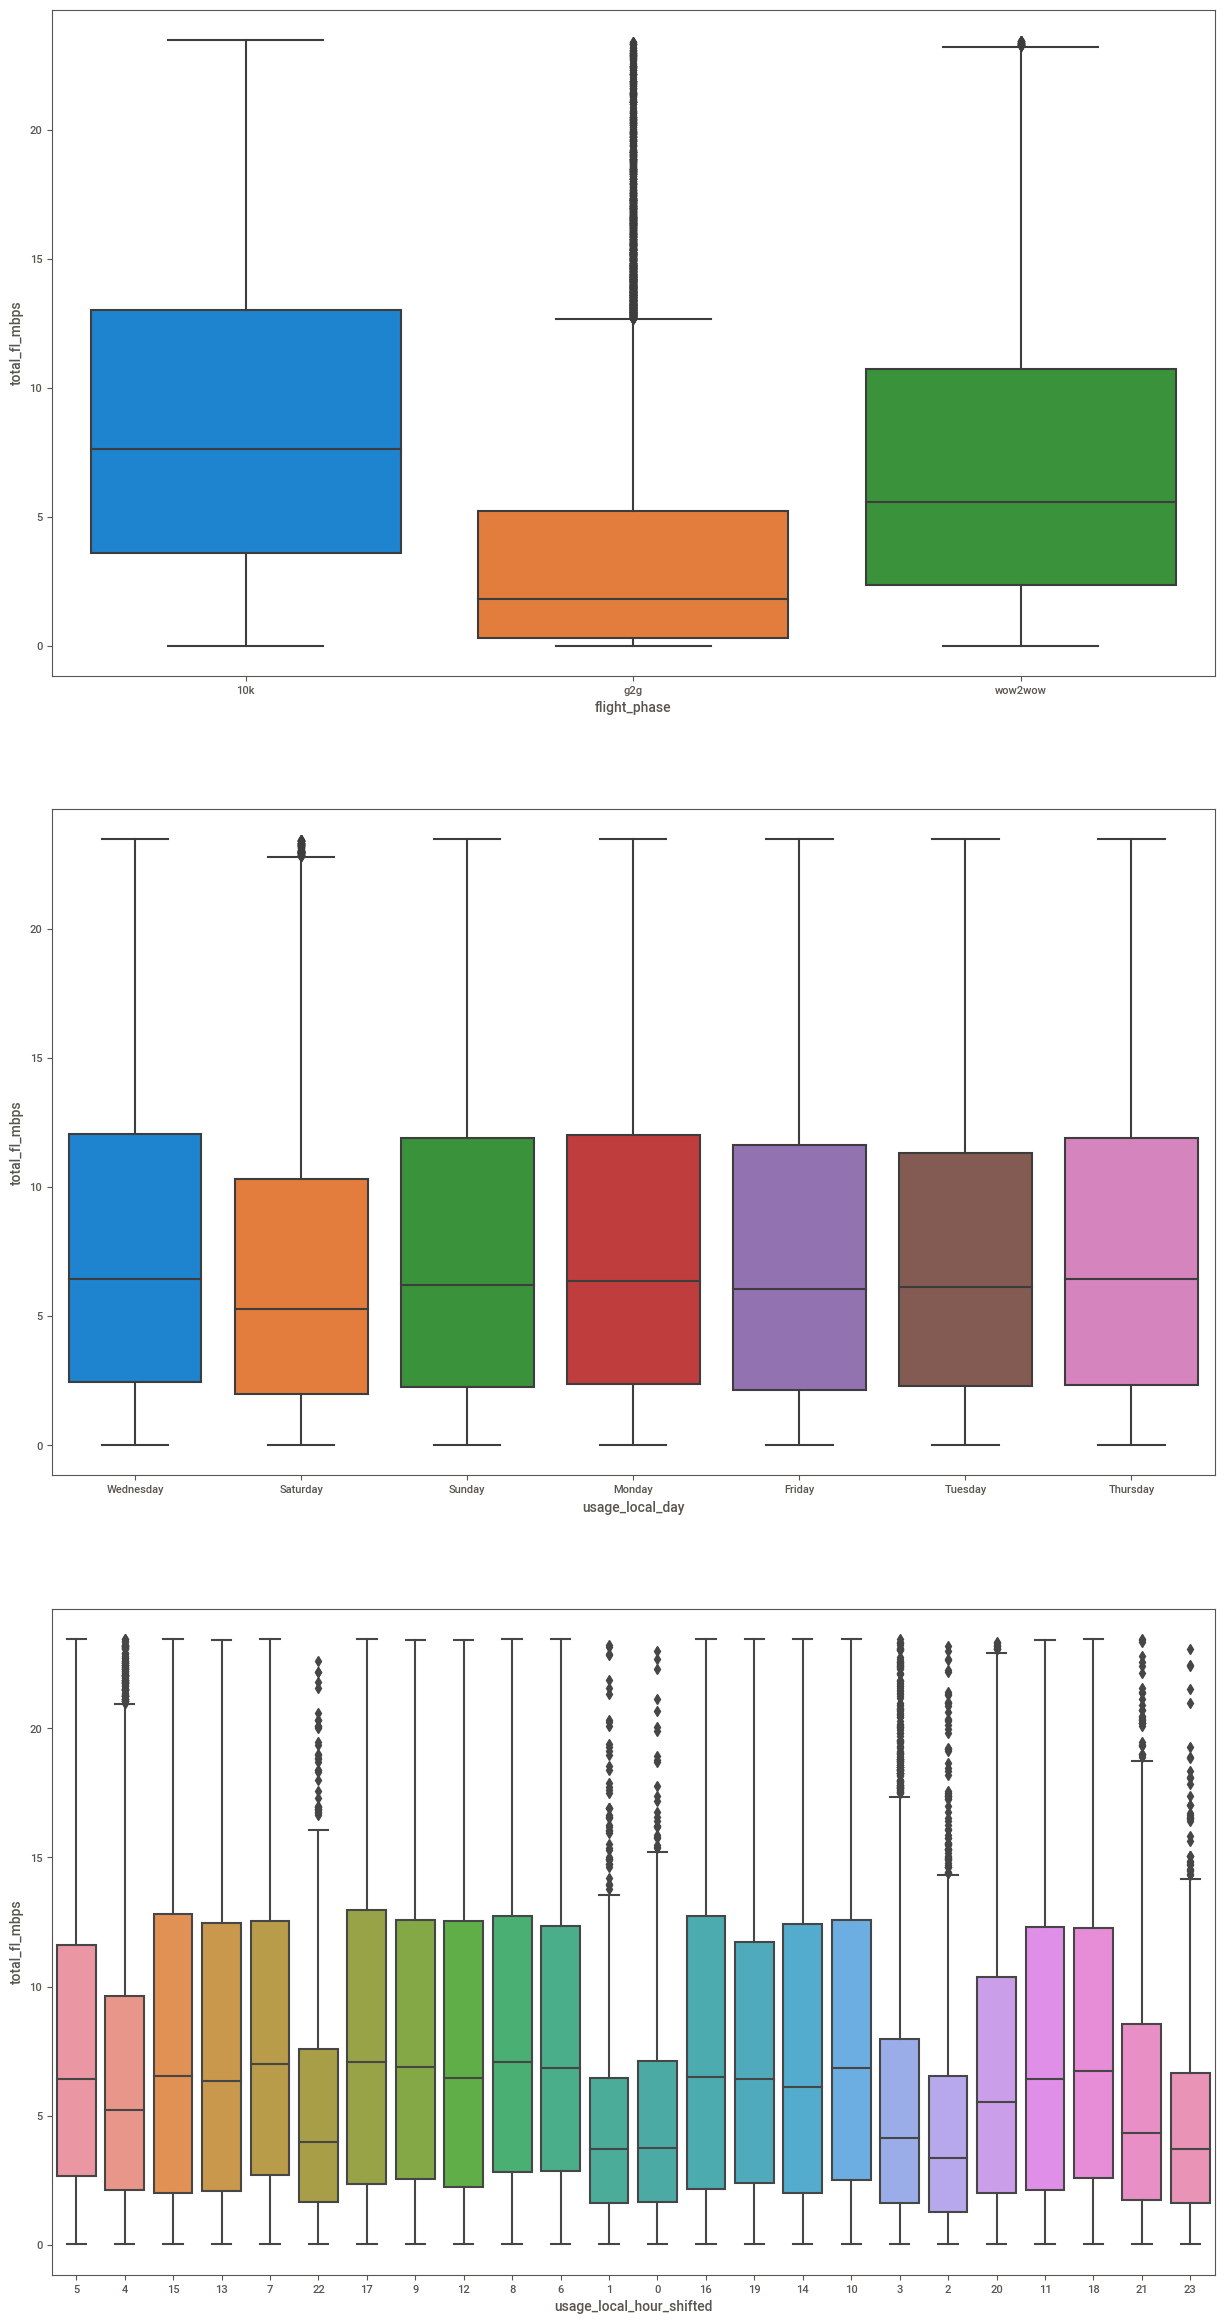

In [31]:
# Creating box plots to better understand the relationship of the categorical variables to the target variable

fig, ax = plt.subplots(3, 1, figsize=(15, 30))
sns.boxplot(x='flight_phase', y='total_fl_mbps', data=df_usage_sampled, ax=ax[0])
sns.boxplot(x='usage_local_day', y='total_fl_mbps', data=df_usage_sampled, ax=ax[1])
sns.boxplot(x='usage_local_hour_shifted', y='total_fl_mbps', data=df_usage_sampled, ax=ax[2])
plt.show()


In [6]:
# Based on the output of the Final run of eda, dropping unwanted columns as well as columns which are not available at the time of prediction ('total_rl_mbps')
df_usage_sampled.drop(columns=['usage_utc_day','usage_utc_hour','usage_local_hour','usage_month','total_rl_mbps'],inplace=True)
df_usage_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120567 entries, 201556 to 2510421
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   airline                   120567 non-null  object 
 1   premium_product           120567 non-null  int64  
 2   esi_product               120567 non-null  int64  
 3   tmo_product               120567 non-null  int64  
 4   basic_product             120567 non-null  int64  
 5   other_product             120567 non-null  int64  
 6   time_into_flight          120567 non-null  float64
 7   flight_phase              120567 non-null  object 
 8   latitude                  120567 non-null  float64
 9   longitude                 120567 non-null  float64
 10  altitude                  120567 non-null  float64
 11  total_fl_mbps             120567 non-null  float64
 12  seat_capacity             120567 non-null  float64
 13  eco_seats                 120567 non-n

In [7]:
# Converting local_hour and pct flight completed to categorical variables based on the output of final eda run
df_usage_sampled['usage_local_hour_shifted'] = df_usage_sampled['usage_local_hour_shifted'].astype('str')
df_usage_sampled['pct_flight_completed'] = round((100*df_usage_sampled['pct_flight_completed']/10),0).astype('str')

In [8]:
# plot a cdf to see the outliers using plotly express for target variable total_fl_mbps
fig = px.histogram(df_usage_sampled, x="total_fl_mbps", nbins=500, title='CDF of total_fl_mbps',cumulative=True, histnorm='probability density')
fig.show()
# fig.write_image("images/cdf_total_fl_mbps.png")

#Throwing outliers in total_fl_mbps which are between 0.1 and  95th percentile
print('After removing outliers in total_fl_mbps, the shape of the cdf is')
df_usage_sampled = df_usage_sampled[ ( df_usage_sampled['total_fl_mbps']<df_usage_sampled['total_fl_mbps'].quantile(0.95)) & (df_usage_sampled['total_fl_mbps']>df_usage_sampled['total_fl_mbps'].quantile(0.001)) ]
fig1 = px.histogram(df_usage_sampled, x="total_fl_mbps", nbins=500, title='CDF of total_fl_mbps',cumulative=True, histnorm='probability density')
fig1.show()

After removing outliers in total_fl_mbps, the shape of the cdf is


### Performing column transformations for categorical and numeric featues

In [9]:
# Applying column transformer to encode categorical variables and scale numeric variables

# Get columns of integer or float type
numeric_cols = df_usage_sampled.select_dtypes(include=['int64', 'float64']).columns
print(numeric_cols)
# Get columns of object type
object_cols = df_usage_sampled.select_dtypes(include=['object']).columns
print(object_cols)

# Categorical feature columns to one-hot encode
categorical_cols = ['airline','flight_phase','usage_local_day','pct_flight_completed','usage_local_hour_shifted','pct_flight_completed']
# Numerical feature columns to standard scale
numerical_cols = ['altitude','seat_capacity','eco_seats']

# Create transformers for one-hot encoding and standard scaling
column_trans = ColumnTransformer(
    transformers=[
        ('ohe',OneHotEncoder(sparse=False), categorical_cols),
        ('std_scaled',StandardScaler(), numerical_cols),
    ],
    remainder='passthrough',
    )
column_trans.set_output(transform='pandas')
transformed_data = column_trans.fit_transform(df_usage_sampled)
df_usage_column_transformed = pd.DataFrame(transformed_data)

df_usage_column_transformed.rename(columns={'remainder__total_fl_mbps':'total_fl_mbps'}, inplace=True)
display(df_usage_column_transformed.head(2))

Index(['premium_product', 'esi_product', 'tmo_product', 'basic_product',
       'other_product', 'time_into_flight', 'latitude', 'longitude',
       'altitude', 'total_fl_mbps', 'seat_capacity', 'eco_seats',
       'free_model'],
      dtype='object')
Index(['airline', 'flight_phase', 'pct_flight_completed',
       'usage_local_hour_shifted', 'usage_local_day'],
      dtype='object')


,ohe__airline_AAL,ohe__airline_AMX,ohe__airline_AZU,ohe__airline_DAL,ohe__airline_DJT,ohe__airline_ELY,ohe__airline_FIN,ohe__airline_ICE,ohe__airline_JBU,ohe__airline_JBU-R,...,remainder__premium_product,remainder__esi_product,remainder__tmo_product,remainder__basic_product,remainder__other_product,remainder__time_into_flight,remainder__latitude,remainder__longitude,total_fl_mbps,remainder__free_model
201556,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,88.0,41.29,-113.40,22.53,1
2269270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,1,1,74.0,39.22,-111.05,1.01,0


### Iterating over different ML Algorithms and  grid searching for hyper parameters within each

In [10]:
# Split the df into train test split with 80:20 ratio 

X = df_usage_column_transformed.loc[:, df_usage_column_transformed.columns != 'total_fl_mbps']
y = df_usage_column_transformed['total_fl_mbps']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining a set of regression models to be used for hyper parameter tuning

regressors = {
    'Linear Regression': (LinearRegression(), {}),
    'Ridge Regression': (Ridge(fit_intercept=False), {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}),
    'Lasso Regression': (Lasso(tol=0.1), {'alpha': [0.00001,0.0001,0.001,0.01, 0.1, 1.0, 10.0, 100.0]}),
    'Random Forest Regressor': (RandomForestRegressor(n_jobs=-1), {'n_estimators': [ 50, 100, 200], 'max_depth': [5, 7, 10, 15, 20, 40]}),
    'AdaBoost Regressor': (AdaBoostRegressor(), {'n_estimators': [20, 50, 100, 200], 'learning_rate': [0.01, 0.1, 1 ,5]}),
    #'Support Vector Regressor': (SVR(), {'C': [1, 10], 'kernel': ['linear', 'rbf']})
}

best_models = []
# Perform grid search for each regressor
for regressor_name, (regressor, param_grid) in regressors.items():
    grid_search = GridSearchCV(regressor, param_grid, scoring='r2', cv=5, verbose=0)
    grid_search.fit(X_train, y_train)

    # Get the best estimator and make predictions
    best_regressor = grid_search.best_estimator_
    y_pred = best_regressor.predict(X_test)

    # Calculate and print the R2 score

    r2 = r2_score(y_test, y_pred)
    print(f"{regressor_name}: Best Parameters: {grid_search.best_params_}, R2 Score: {r2}")
    best_models.append({'regressor':regressor_name,'model':best_regressor})


Linear Regression: Best Parameters: {}, R2 Score: 0.4249325313413552
Ridge Regression: Best Parameters: {'alpha': 1.0}, R2 Score: 0.42492995789348686
Lasso Regression: Best Parameters: {'alpha': 1e-05}, R2 Score: 0.4249359545544732
Random Forest Regressor: Best Parameters: {'max_depth': 40, 'n_estimators': 200}, R2 Score: 0.5194958133761531
AdaBoost Regressor: Best Parameters: {'learning_rate': 0.01, 'n_estimators': 20}, R2 Score: 0.34947569951013513


[{'regressor': 'Linear Regression', 'model': LinearRegression()}, {'regressor': 'Ridge Regression', 'model': Ridge(fit_intercept=False)}, {'regressor': 'Lasso Regression', 'model': Lasso(alpha=1e-05, tol=0.1)}, {'regressor': 'Random Forest Regressor', 'model': RandomForestRegressor(max_depth=40, n_estimators=200, n_jobs=-1)}, {'regressor': 'AdaBoost Regressor', 'model': AdaBoostRegressor(learning_rate=0.01, n_estimators=20)}]
{'Linear Regression': LinearRegression(), 'Ridge Regression': Ridge(fit_intercept=False), 'Lasso Regression': Lasso(alpha=1e-05, tol=0.1), 'Random Forest Regressor': RandomForestRegressor(max_depth=40, n_estimators=200, n_jobs=-1), 'AdaBoost Regressor': AdaBoostRegressor(learning_rate=0.01, n_estimators=20)}


In [16]:
# Generic funcitons for calculating error metrics and creating a unified dataframe for it

def create_regression_metrics_dataframe(models_dict, X_test, y_test):
    # Create an empty DataFrame to store error metrics
    error_metrics_df = pd.DataFrame()

    # Iterate over the models in the dictionary
    for model_name, model in models_dict.items():
        # Predict the target variable on the test set
        y_pred = model.predict(X_test)

        # Calculate test error metrics
        mse = round(mean_squared_error(y_test, y_pred),2)
        rmse = round(mean_squared_error(y_test, y_pred, squared=False),2)
        mae = round(mean_absolute_error(y_test, y_pred),2)
        mape = round(mean_absolute_percentage_error(y_test, y_pred),2)
        r2 = round(r2_score(y_test, y_pred),2)

        # Create a DataFrame to store the error metrics for the current model
        model_metrics = pd.DataFrame({
            'Model': [model_name],
            'Mean Squared Error (MSE)': [mse],
            'Root Mean Squared Error (RMSE)': [rmse],
            'Mean Absolute Error (MAE)': [mae],
            'Mean Absolute Percentage Error (MAPE)': [mape],
            'R^2 Score': [r2]
        })

        # Append the model metrics DataFrame to the main error_metrics_df
        error_metrics_df = error_metrics_df.append(model_metrics, ignore_index=True)

    return error_metrics_df

# converting the best_models list into a dictionary
best_models_dict = dict((i['regressor'], i['model']) for i in best_models)

df_model_perf = create_regression_metrics_dataframe(best_models_dict, X_test, y_test)

display(df_model_perf)


,Model,Mean Squared Error (MSE),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),Mean Absolute Percentage Error (MAPE),R^2 Score
0,Linear Regression,21.53,4.64,3.64,10.11,0.42
1,Ridge Regression,21.53,4.64,3.64,10.11,0.42
2,Lasso Regression,21.53,4.64,3.64,10.11,0.42
3,Random Forest Regressor,17.99,4.24,3.15,5.58,0.52
4,AdaBoost Regressor,24.36,4.94,3.85,8.58,0.35


Best Regressor is RandomForestRegressor(max_depth=40, n_estimators=200, n_jobs=-1)


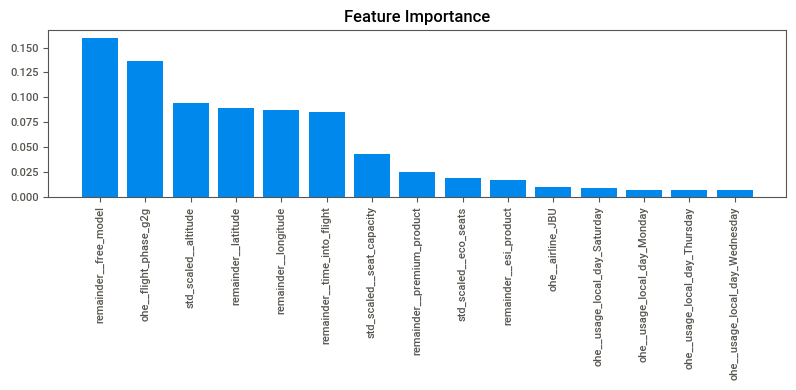

In [27]:
# Understanding feature importance of the best regressor model 

print("Best Regressor is {}".format(best_models_dict['Random Forest Regressor']))

importances = best_models_dict['Random Forest Regressor'].feature_importances_
# Sort feature importances in descending order and picking top 15 features
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices[:15]]
sorted_features = X_test.columns[indices[:15]]


# Plot the feature importances
plt.figure(figsize=(8, 4))
plt.title("Feature Importance")
plt.bar(range(15), sorted_importances, align="center")
plt.xticks(range(15), sorted_features, rotation=90)
plt.tight_layout()
plt.show()